In [1]:
pip install k-means-constrained

In [2]:
from k_means_constrained import KMeansConstrained

import numpy as np
import pandas as pd
import scipy
import folium
import math
import matplotlib.pyplot as plt

from scipy.spatial import distance
from math import radians,cos,sin

https://www.ibon.com.tw/retail_inquiry.aspx#gsc.tab=0 \
I then Paste the adresses in to google sheets and ustalize the geocoding by smartmokey extension and get the longitude and latitude for each of the 711 adresses. I fromat these and import them in to the code as a CSV file. Due to the trouble of handeling chinese ccharectors I connect eatch longitude and latidtude with the uniqe store number.

https://sheethub.com/ronnywang/%E9%84%89%E9%8E%AE%E5%B8%82%E5%8D%80%E8%A1%8C%E6%94%BF%E5%8D%80%E5%9F%9F%E7%95%8C%E7%B7%9A/uri/19260536

https://github.com/joshlk/k-means-constrained


# **Process the 7/11 location data**

In [3]:
positions = pd.read_csv('711_data.csv')
positions[['Latitude','Longitude']]=positions['Latitude, Long'].str.split(',',expand=True).astype(float)
positions['Coords'] = list(zip(positions.Latitude, positions.Longitude))

### Converting Longitude and Latitude into Cartesian X and Y

R of earth =6371 KM
 x = R * cos( radiance(lat) ) * cos(radiance (lon))
 y = R * cos( radiance(lat) ) * sin(radiance (lon))


 http://www.geomidpoint.com/example.html
Converting the long,lat to x,y cordinates

In [4]:
lat = positions["Latitude"].map(radians)
lon = positions["Longitude"].map(radians)

x = lon.map(cos)*lat.map(cos)*6371
y= lon.map(cos)*lat.map(sin)*6371

positions["lat_radians"] = lat
positions["lon_radians"] = lon
positions["x"] = x
positions["y"] = y
positions["z"]= np.linalg.norm(positions["x"].values - positions["y"].values)
positions['xy'] = list(zip(positions.x, positions.y))




# **Cluser the 7/11 togheter and find clusers for assigment to workers**

In [5]:
clf = KMeansConstrained(n_clusters=15,size_min=4,size_max=8,random_state=0)
clf.fit_predict(positions['Coords'].tolist())
clf.cluster_centers_
clf.labels_
print(clf.labels_)
positions['Cluster_long_lat'] = clf.labels_

[ 4  9  8 10 11 12 10 11  4  2  2 12 11 10  7  2  6  1  7  6  4  7  9 13
  9  1 11  0  3  2 11  2  6  0  4 12  0 14  5 14  9  5 14  5 11  0 13 13
  5  4  8  1  6  1 10  8 13  0  5  7  6  3  3  5 11  8  4  5  0 14  0 12
  3  0  3 13  9  9 14  6 11]


In [6]:
clf = KMeansConstrained(n_clusters=15,size_min=4,size_max=8,random_state=0)
clf.fit_predict(list(zip(positions.x, positions.y)))
clf.cluster_centers_
clf.labels_
positions['Cluster_xy'] = clf.labels_

In [7]:
display(positions[['store_name', 'Cluster_xy']])

,store_name,Cluster_xy
0,松山,7
1,醫學,9
2,福中,4
3,喬治,10
4,新三連,11
...,...,...
76,信醫,2
77,北醫,9
78,宏泰,12
79,松家,13


# TSP on each clusters to find the optimal routh for eatch 7/11

In [8]:
import numpy as np
import pandas as pd

def dist(a, b, coords, tour):
    """Return the euclidean distance between cities tour[a] and tour[b]."""
    return np.hypot(coords[tour[a]][0] - coords[tour[b]][0], coords[tour[a]][1] - coords[tour[b]][1])

def two_opt_python(TSP):
    coords = TSP['xy']
    tour = np.array([i for i in range(len(coords))])

    num_cities = len(tour)
    improvement = True
    while improvement:
        improvement = False
        min_change = 0
        # Find the best move
        for i in range(num_cities - 2):
            for j in range(i + 2, num_cities - 1):
                change = dist(i, j, coords, tour) + dist(i+1, j+1, coords, tour) - dist(i, i+1, coords, tour) - dist(j, j+1, coords, tour)
                if change < min_change:
                    min_change = change
                    min_i, min_j = i, j
        # Update tour with best move
        if min_change < 0:
            tour[min_i+1:min_j+1] = tour[min_i+1:min_j+1][::-1]
            improvement = True  # there was an improvement, so continue the loop

    # Calculate total distance of the tour
    total_distance = sum(dist(i, (i+1)%num_cities, coords, tour) for i in range(num_cities))
    return tour, total_distance

# Group by 'Cluster_xy' and apply TSP algorithm
groups = positions.groupby('Cluster_xy')
total_distances_with_tsp = {}
for name, group in groups:
    # Reset index for current group
    group = group.reset_index(drop=False)  # 'drop=False' will make the original index into a column
    tour, total_distance = two_opt_python(group)
    total_distances_with_tsp[name] = total_distance
    # Reorder the rows of the group according to the order found by the TSP algorithm
    reordered_group = group.iloc[tour]
    # Restore original index
    reordered_group.set_index('index', inplace=True, drop=True)
    # Save the result back into the original dataframe
    positions.loc[reordered_group.index] = reordered_group

    print(f"Tour for cluster {name}: {tour.tolist()}")
    print(f"Stores visited in tour for cluster {name}: {reordered_group['store_name'].tolist()}\n")
    print(f"Total distance for cluster {name}: {total_distance}\n")


Tour for cluster 0: [0, 2, 3, 1, 4]
Stores visited in tour for cluster 0: ['捷忠', '後山埤', '春光', '廣林', '光東']

Total distance for cluster 0: 0.8725693559966072

Tour for cluster 1: [0, 1, 2, 3, 4]
Stores visited in tour for cluster 1: ['光復', '昌隆', '信富', '松敬', '中興']

Total distance for cluster 1: 0.9890694156360369

Tour for cluster 2: [0, 2, 4, 3, 1, 5]
Stores visited in tour for cluster 2: ['富比世', '總站', '惠安', '松仁', '北府', '信醫']

Total distance for cluster 2: 1.0678199177207133

Tour for cluster 3: [0, 1, 3, 2, 4]
Stores visited in tour for cluster 3: ['敦厚', '永信', '忠隆', '新光', '鑫國泰']

Total distance for cluster 3: 0.7115391415677709

Tour for cluster 4: [0, 2, 1, 3]
Stores visited in tour for cluster 4: ['福中', '廣慈', '信福', '留公']

Total distance for cluster 4: 0.9236794692053527

Tour for cluster 5: [0, 1, 2, 3, 4, 5]
Stores visited in tour for cluster 5: ['仁和', '凱悅', '國貿', '世貿', '世貿二', '興貿']

Total distance for cluster 5: 1.0329727419582817

Tour for cluster 6: [0, 1, 2, 3]
Stores visited in 

<Figure size 1500x800 with 0 Axes>

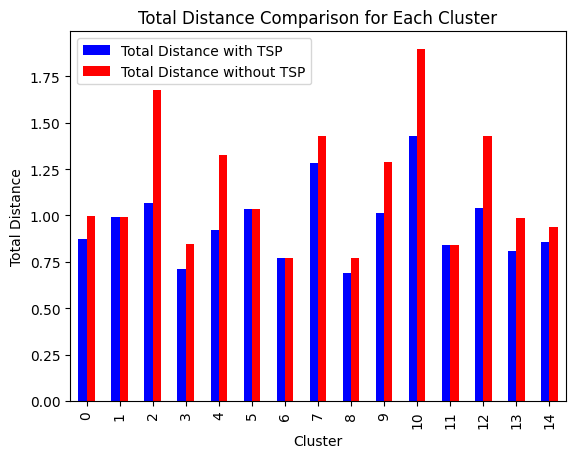

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define your data
data = {'Cluster': np.arange(0, 15),
        'Total Distance with TSP': [0.8725693559966072, 0.9890694156360369, 1.0678199177207133, 0.7115391415677709,
                                     0.9236794692053527, 1.0329727419582817, 0.7694495357952365, 1.2839513118902017,
                                     0.690986138020766, 1.01314142364435, 1.426285605901471, 0.8427010774325971,
                                     1.040073196802327, 0.8094911393588266, 0.8584653382789587],
        'Total Distance without TSP': [0.9967883231666366, 0.9890694156360369, 1.6759564336450876, 0.8458735617945704,
                                       1.3253673752719888, 1.0329727419582817, 0.7694495357952365, 1.4301298206996744,
                                       0.7689862937659309, 1.2894426186330326, 1.8973302671609995, 0.8427010774325971,
                                       1.4277863781091826, 0.986502161163983, 0.9377501930608073]}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a bar plot
df.plot(kind='bar', x='Cluster', y=['Total Distance with TSP', 'Total Distance without TSP'], color=['blue', 'red'])

# Set the title and labels
plt.title('Total Distance Comparison for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Distance')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [10]:
positions.head()

,Store_nr,store_name,Address,"Latitude, Long",Address found,Latitude,Longitude,Coords,lat_radians,lon_radians,x,y,z,xy,Cluster_long_lat,Cluster_xy
0,118970,松山,台北市信義區忠孝東路五段386號,"25.0407495,121.5741676","No. 386, Section 5 of Zhongxiao East RoadSecti...",25.040750,121.574168,"(25.0407495, 121.5741676)",0.437044,2.121870,-3022.319115,-1411.948326,14494.151754,"(-3022.3191154573105, -1411.9483260919646)",4,7
1,119478,醫學,台北市信義區吳興街257號259號,"25.0271406,121.5637318","259 号, No. 257, Wuxing St, Xinyi District, Tai...",25.027141,121.563732,"(25.0271406, 121.5637318)",0.436806,2.121687,-3021.758546,-1410.812166,14494.151754,"(-3021.7585458524472, -1410.812166011862)",9,9
2,120353,福中,台北市信義區福德街159號161號1樓,"25.0376675,121.5833132","161 号 1, No. 159, Fude St, Xinyi District, Tai...",25.037668,121.583313,"(25.0376675, 121.5833132)",0.436990,2.122029,-3023.180006,-1412.152405,14494.151754,"(-3023.1800060548126, -1412.152404546937)",8,4
3,120515,喬治,台北市信義區基隆路二段155號1樓,"25.0259016,121.5545101","1樓, No. 155號, Section 2, Keelung Rd, Xinyi Dis...",25.025902,121.554510,"(25.0259016, 121.5545101)",0.436784,2.121526,-3020.997335,-1410.377201,14494.151754,"(-3020.9973346987595, -1410.3772009349152)",10,10
4,121079,新三連,台北市信義區逸仙路42巷25號1樓,"25.0404207,121.56315","1樓, No. 25號, Lane 42, Yixian Rd, Xinyi Distric...",25.040421,121.563150,"(25.0404207, 121.56315)",0.437038,2.121677,-3021.381523,-1411.489185,14494.151754,"(-3021.381523004975, -1411.489184705502)",11,11


# **Mapping the Clusters**

In [11]:
#Start with mapping all the 7/11 stores found in the xinyi area. Visualize the location and give each cluster a colour
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink',
 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

map = folium.Map(location=[positions['Latitude'][1], positions['Longitude'][1]],tiles="Cartodb Positron", zoom_start=14)
folium.GeoJson("xinyi.geojson", name="geojson").add_to(map)

for i in range(len(positions['Latitude'])):
  folium.CircleMarker(
          location=[positions['Latitude'][i], positions['Longitude'][i]],
          radius=4,
          weight=2,
          popup=positions['store_name'][i],
          fill = True,
          fill_color = 'black',
          color = 'black'
      ).add_to(map)
map

In [12]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink',
 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

map = folium.Map(location=[positions['Latitude'][1], positions['Longitude'][1]],tiles="Cartodb Positron", zoom_start=14)
folium.GeoJson("xinyi.geojson", name="geojson").add_to(map)

for i in range(len(positions['Latitude'])-1):
  folium.CircleMarker(
          location=[positions['Latitude'][i], positions['Longitude'][i]],
          radius=4,
          weight=2,
          popup=positions['store_name'][i],
          fill = True,
          fill_color = colors[int(positions['Cluster_long_lat'][i])],
          color = colors[int(positions['Cluster_long_lat'][i])]
      ).add_to(map)
map